In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ssbd_path ='/content/drive/MyDrive/ssbd'


In [ ]:
!pip install tensorflow-docs


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 2.2 MB/s eta 0:00:00


In [ ]:
%cd /content/drive/MyDrive/ssbd_training

/content/drive/MyDrive/ssbd_training


In [ ]:
import glob
import pandas as pd
import cv2
import gc
import numpy as np
import random
import imageio
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt

In [ ]:
class CFG:
    epochs = 30
    batch_size = 32
    classes = ["armFlapping", "headBanging", "spinning"]

In [ ]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')

In [ ]:
file_paths = []
targets = []
for i, cls in enumerate(CFG.classes):
    sub_file_paths = glob.glob(f"{ssbd_path}/{cls}/**.mp4")
    print(sub_file_paths)
    file_paths += sub_file_paths
    targets += [i] * len(sub_file_paths)

['/content/drive/MyDrive/ssbd/armFlapping/armFlapping_3.mp4', '/content/drive/MyDrive/ssbd/armFlapping/armFlapping_1.mp4', '/content/drive/MyDrive/ssbd/armFlapping/armFlapping_2.mp4', '/content/drive/MyDrive/ssbd/armFlapping/armFlapping_4.mp4', '/content/drive/MyDrive/ssbd/armFlapping/armFlapping_5.mp4', '/content/drive/MyDrive/ssbd/armFlapping/armFlapping_6.mp4', '/content/drive/MyDrive/ssbd/armFlapping/armFlapping_7.mp4', '/content/drive/MyDrive/ssbd/armFlapping/armFlapping_8.mp4', '/content/drive/MyDrive/ssbd/armFlapping/armFlapping_9.mp4', '/content/drive/MyDrive/ssbd/armFlapping/armFlapping_10.mp4', '/content/drive/MyDrive/ssbd/armFlapping/armFlapping_11.mp4', '/content/drive/MyDrive/ssbd/armFlapping/armFlapping_14.mp4', '/content/drive/MyDrive/ssbd/armFlapping/armFlapping_12.mp4', '/content/drive/MyDrive/ssbd/armFlapping/armFlapping_15.mp4', '/content/drive/MyDrive/ssbd/armFlapping/armFlapping_13.mp4', '/content/drive/MyDrive/ssbd/armFlapping/armFlapping_18.mp4', '/content/drive/

(20, 224, 224, 3)



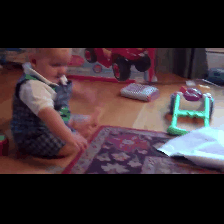

In [ ]:
sample_video = frames_from_video_file(file_paths[5], n_frames = 20)
print(sample_video.shape)
to_gif(sample_video)

In [ ]:
features = []
for file_path in tqdm(file_paths):
    features.append(frames_from_video_file(file_path, n_frames = 10))
features = np.array(features)

  0%|          | 0/62 [00:00<?, ?it/s]

In [ ]:
train_features, val_features, train_targets, val_targets = train_test_split(features, targets, test_size=0.2, random_state=42)
train_features.shape, val_features.shape, len(train_targets), len(val_targets)

((49, 10, 224, 224, 3), (13, 10, 224, 224, 3), 49, 13)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_targets)).shuffle(CFG.batch_size * 4).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
valid_ds = tf.data.Dataset.from_tensor_slices((val_features, val_targets)).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
del train_features
del val_features
gc.collect()

0

In [ ]:
for X, y in train_ds.take(1):
    print(X.shape, y.shape)

(32, 10, 224, 224, 3) (32,)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(10, 224, 224, 3)),
    tf.keras.layers.Conv3D(32, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(),
    tf.keras.layers.Conv3D(64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(),
    tf.keras.layers.Conv3D(128, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(len(CFG.classes), activation="softmax")
])
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=[
        "accuracy"
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 224, 224, 32   2624      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 5, 112, 112, 32)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 112, 112, 64)   55360     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 2, 56, 56, 64)     0         
 g3D)                                                            
                                                                 
 conv3d_2 (Conv3D)           (None, 2, 56, 56, 128)    221312    
                                                        

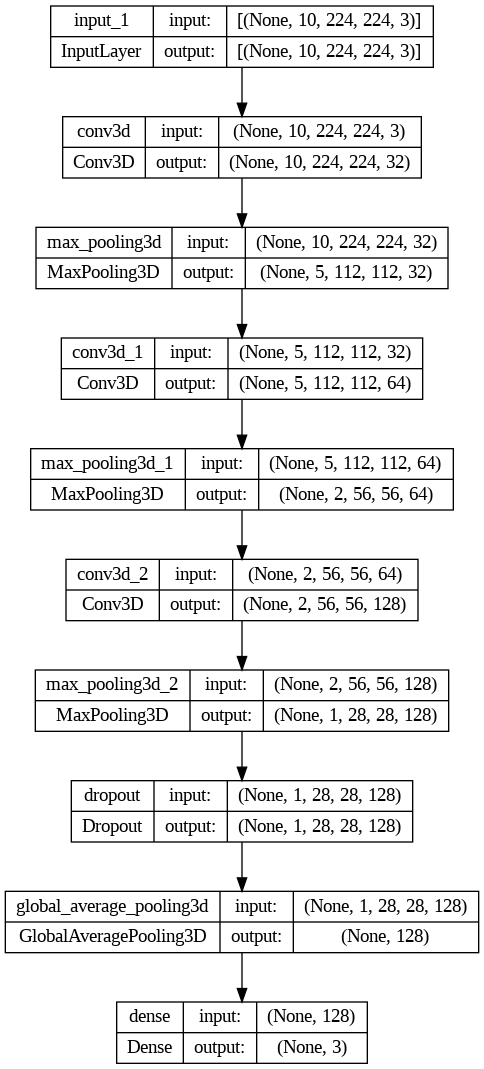

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    restore_best_weights=True
)
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds,
    callbacks=[checkpoint]
)
model.load_weights("model.h5")

Epoch 1/50
2/2 [==============================] - 81s 32s/step - loss: 1.0987 - accuracy: 0.2857 - val_loss: 1.1424 - val_accuracy: 0.1538
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 79s 31s/step - loss: 1.0412 - accuracy: 0.4082 - val_loss: 1.2701 - val_accuracy: 0.1538
Epoch 3/50
2/2 [==============================] - 82s 35s/step - loss: 1.0594 - accuracy: 0.4082 - val_loss: 1.1998 - val_accuracy: 0.1538
Epoch 4/50
2/2 [==============================] - 82s 36s/step - loss: 1.0419 - accuracy: 0.4082 - val_loss: 1.1520 - val_accuracy: 0.1538
Epoch 5/50
2/2 [==============================] - 77s 31s/step - loss: 1.0311 - accuracy: 0.4286 - val_loss: 1.1504 - val_accuracy: 0.2308
Epoch 6/50
2/2 [==============================] - 82s 34s/step - loss: 1.0168 - accuracy: 0.4898 - val_loss: 1.1844 - val_accuracy: 0.2308
Epoch 7/50
2/2 [==============================] - 76s 30s/step - loss: 1.0071 - accuracy: 0.4898 - val_loss: 1.2093 - val_accuracy: 0.2308
Epoch 8/50
2/2 [==============================] - 79s 33s/step - loss: 0.9999 - accuracy: 0.5102 - val_loss: 1.1670 - val_accuracy: 0.2308
Epoch 9/50
2/2 [======================

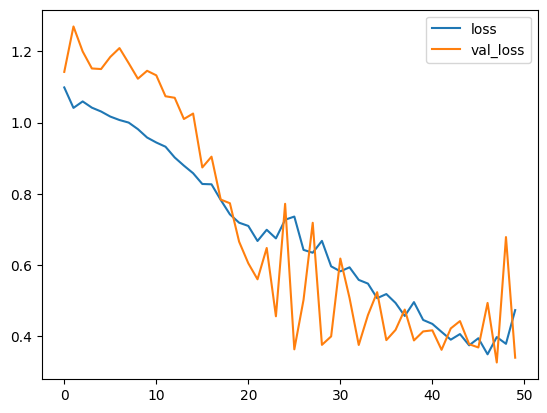

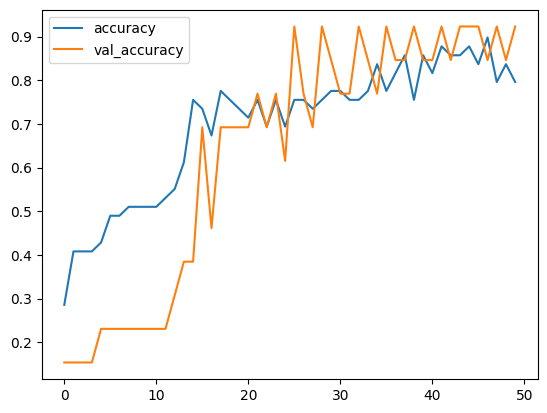

In [ ]:
for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    pd.DataFrame(history.history, columns=metrics).plot()
    plt.show()

In [ ]:
val_loss, val_acc = model.evaluate(valid_ds)
print(f"Validation Loss:{val_loss} Validation Accuracy:{val_acc}")

1/1 [==============================] - 5s 5s/step - loss: 0.3626 - accuracy: 0.9231
Validation Loss:0.3625984191894531 Validation Accuracy:0.9230769276618958


In [ ]:
%cd /content/drive/MyDrive/ssbd_training/

/content/drive/MyDrive/ssbd_training


In [ ]:
from tensorflow.keras.models import load_model
model=load_model("model.h5")

1/1 [==============================] - 6s 6s/step


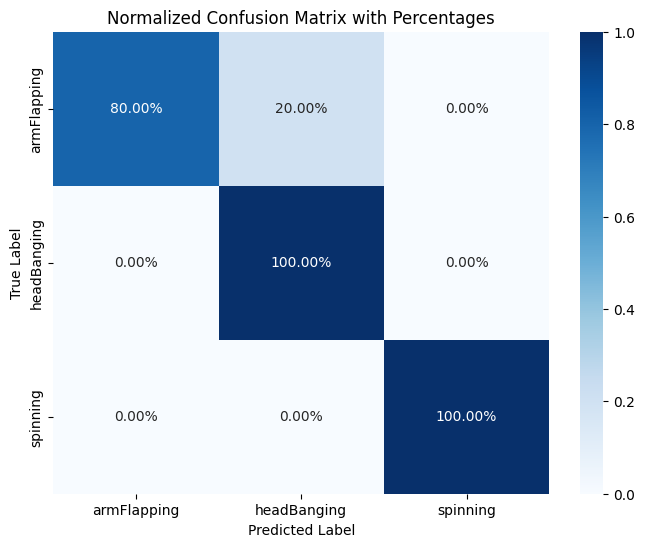

Classification Report:
              precision    recall  f1-score   support

 armFlapping       1.00      0.80      0.89         5
 headBanging       0.67      1.00      0.80         2
    spinning       1.00      1.00      1.00         6

    accuracy                           0.92        13
   macro avg       0.89      0.93      0.90        13
weighted avg       0.95      0.92      0.93        13



In [ ]:


import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming valid_ds is defined as your validation dataset
# valid_ds = ...

# Assuming classes is defined as your list of class names
classes = ["armFlapping", "headBanging", "spinning"]

# Make predictions on the validation set
predictions = model.predict(valid_ds)

# Get true labels from the validation dataset
true_labels = np.concatenate([y.numpy() for x, y in valid_ds], axis=0)

# Get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix with percentages using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Normalized Confusion Matrix with Percentages")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))




2/2 [==============================] - 27s 11s/step


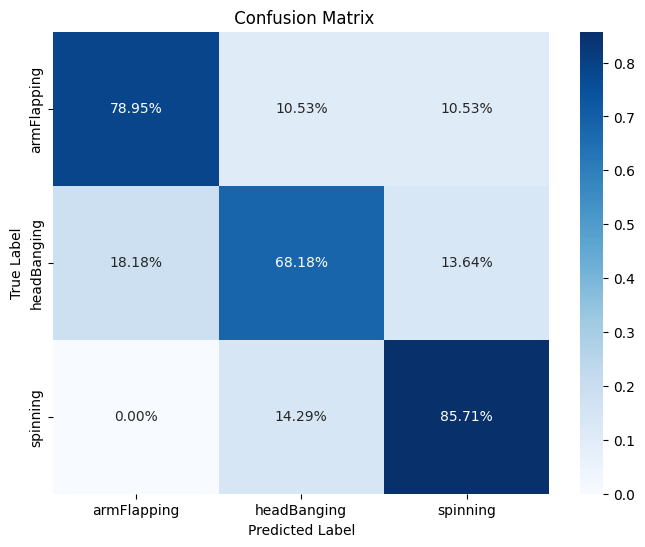

Classification Report:
              precision    recall  f1-score   support

 armFlapping       0.79      0.79      0.79        19
 headBanging       0.75      0.68      0.71        22
    spinning       0.78      0.86      0.82        21

    accuracy                           0.77        62
   macro avg       0.77      0.78      0.77        62
weighted avg       0.77      0.77      0.77        62



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Assuming features and targets are already defined
# features = ...
# targets = ...

# Split the data into training and validation sets
train_features, val_features, train_targets, val_targets = train_test_split(features, targets, test_size=0.2, random_state=42)

# Combine training and validation data
all_features = np.concatenate([train_features, val_features], axis=0)
all_targets = np.concatenate([train_targets, val_targets], axis=0)

# Create a TensorFlow dataset for the entire dataset
all_ds = tf.data.Dataset.from_tensor_slices((all_features, all_targets)).batch(CFG.batch_size)

# Make predictions on the entire dataset
all_predictions = model.predict(all_ds)

# Get true labels
# Get true labels (if targets are not one-hot encoded)
true_labels = all_targets  # If your targets are not one-hot encoded

# Get predicted labels
predicted_labels = np.argmax(all_predictions, axis=1)

# Calculate and plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


# Plot confusion matrix with percentages using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title(" Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))


In [ ]:
# Load and preprocess test data
test_file_paths = ["/content/drive/MyDrive/ssbd/armFlapping/armFlapping_11.mp4"]  # Paths to your test video files
test_features = []
classes = ["armFlapping", "headBanging", "spinning"]
for file_path in test_file_paths:
    test_features.append(frames_from_video_file(file_path, n_frames=10))

test_features = np.array(test_features)

# Create TensorFlow dataset for test set
test_ds = tf.data.Dataset.from_tensor_slices((test_features)).batch(CFG.batch_size)

# Make predictions
predictions = model.predict(test_ds)

# If you want class predictions (argmax), you can do the following:
class_predictions = np.argmax(predictions, axis=1)

for idx in class_predictions:
    class_name = classes[idx]
    print(f"Predicted class: {class_name}")

1/1 [==============================] - 0s 456ms/step
Predicted class: armFlapping
